<a href="https://colab.research.google.com/github/wonderalexandre/MorphoTreeAdjust/blob/main/notebooks/morphoTreeAdjust_example_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Library

In [1]:
!pip install morphoTreeAdjust
!pip install PrettyPrintTree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for morphoTreeAdjust: filename=morphoTreeAdjust-0.1.8-cp311-cp311-linux_x86_64.whl size=202214 sha256=cea9e6a0ba8340fd1f6101669aa3a918400243fd15cef13f935673e42f949c6b
  Stored in directory: /root/.cache/pip/wheels/9b/8e/68/5849f077549d26da05e983cbc89824b1098300044fe5dcc600
Successfully built morphoTreeAdjust
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 7.8 MB/s eta 0:00:00


# 2. Importing library

In [1]:
import numpy as np
import cv2 as cv
import morphoTreeAdjust as mta
from morphoTreeAdjust import utils as mta_utils

# 3. Creating the min-tree and max-tree of an input image

Upper and lower level sets where in the black (highlighted are cnps) are foreground pixels and white are background pixels


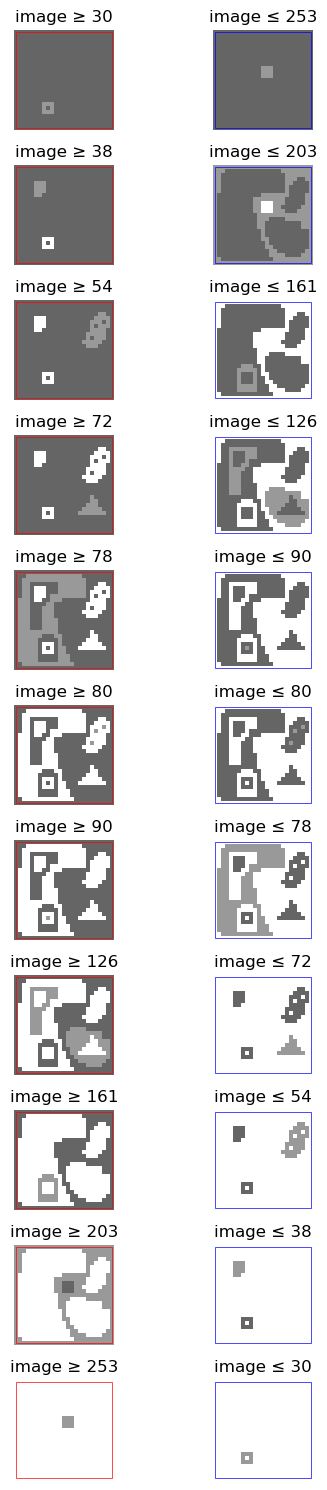




Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


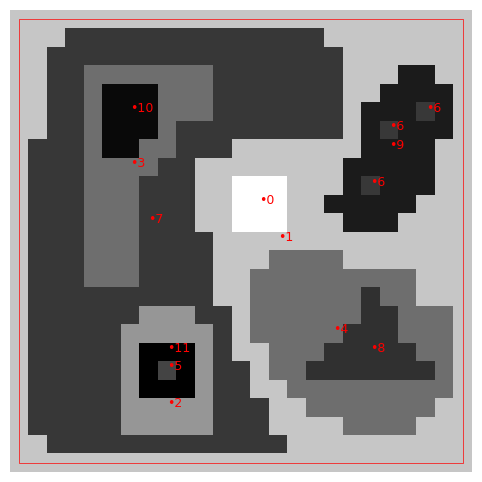

                                 0: 253: 625 
                                      |
                                 1: 203: 616 
                     ┌────────────────┴────┬────────────┐
                2: 161: 277            4: 126: 84   6: 80: 38 
           ┌─────────┴─────────┐           |            |     
      3: 126: 244           5: 90: 9   8: 72: 18    9: 54: 35 
     ┌─────┴──────┐            |                              
 7: 78: 191   10: 38: 11   11: 30: 8 



Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


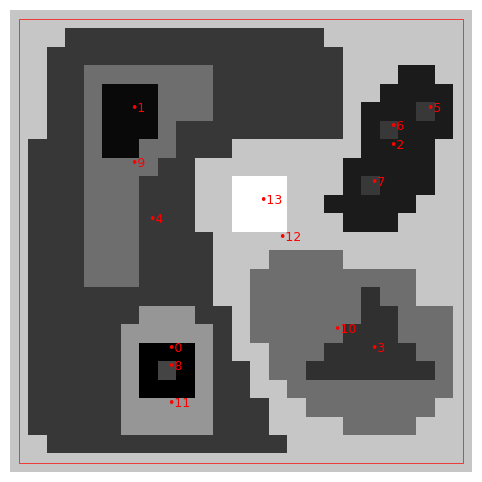

                                                         0: 30: 625 
                                           ┌─────────────────┴─────────────────┐
                                       1: 38: 616                           8: 90: 1 
                                           |                                         
                                       2: 54: 605                                    
                   ┌───────────────────────┴──┬──────────┬──────────┐                
               3: 72: 567                  5: 80: 1   6: 80: 1   7: 80: 1            
                   |                                                                 
               4: 78: 549                                                            
     ┌─────────────┼──────────────┐                                                  
 9: 126: 42   10: 126: 292   11: 161: 24                                             
                   |                                                        

In [3]:
img_jmiv =  np.array([
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203,203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203],
[203,203, 78, 78,126,126,126,126,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203,203, 54, 54,203,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203, 54, 54, 54, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203, 54, 54, 54, 80, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126, 78, 78, 78, 78, 78, 78, 78, 78, 78,203, 54, 80, 54, 54, 54,203],
[203, 78, 78, 78,126, 38, 38,126,126, 78, 78, 78,203,203,203,203,203,203,203, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126,126, 78, 78,203,203,203,203,203,203,203,203, 54, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 80, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203, 54, 54, 54, 54, 54,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 54, 54,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,126,126,126,126,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,126,126,126,126,126,126, 72,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78,161,161,161, 78, 78,203,126,126,126,126,126,126, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78,203,126,126,126,126,126, 72, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78,203,203,126,126,126, 72, 72, 72, 72, 72,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 90, 30,161, 78, 78,203,126,126, 72, 72, 72, 72, 72, 72, 72,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,126,126,126,126,126,126,126,203,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,203,203,126,126,126,126,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203],
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203]
], dtype=np.uint8)



num_rows, num_cols = img_jmiv.shape
#img_jmiv = img_jmiv.ravel()

graph = mta.FlatZonesGraph(img_jmiv, num_rows, num_cols, 1.5)
maxtree = mta.ComponentTree(graph, True)
mintree = mta.ComponentTree(graph, False)

mta_utils.showLevelSets(img_jmiv)
print("\n\n")
mta_utils.showTree(mintree)
print("\n\n")
mta_utils.showTree(maxtree)


# 4. Pruning a leaf of the max-tree and adjusting the min-tree

### 4.1 Selecting the leaf

List of leaves of the min-tree:
	-  NodeCT(id=8, level=72, parentID=4, numCNPs=18, numFlatzones=1, area=18)
	-  NodeCT(id=9, level=54, parentID=6, numCNPs=35, numFlatzones=1, area=35)
	-  NodeCT(id=7, level=78, parentID=3, numCNPs=191, numFlatzones=1, area=191)
	-  NodeCT(id=10, level=38, parentID=3, numCNPs=11, numFlatzones=1, area=11)
	-  NodeCT(id=11, level=30, parentID=5, numCNPs=8, numFlatzones=1, area=8)



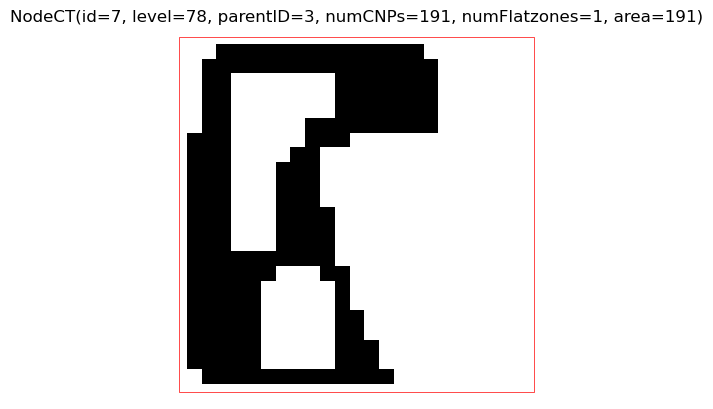

In [8]:
leaves_mintree = mintree.leaves()
print("List of leaves of the min-tree:")
for leaf in leaves_mintree:
    print("\t- ", leaf)
    
print()
L = leaves_mintree[2]
mta_utils.showNode(maxtree, L)

### 4.2 Inspect the sets $F_\lambda$ and $F_{\lambda>b}$

In [11]:
adjust = mta.ComponentTreeAdjustmentByLeaf(mintree, maxtree)

oldGrayLevel = L.level
newGrayLevel = L.parent.level

(F_λ, F_λb) = adjust.buildCollections(maxtree, L, newGrayLevel)

print("f(p) = a = ", oldGrayLevel)
print("g(p) = b = ", newGrayLevel)
print("\n-------------------------------------------------------------------------------------\n")
print("F_λ:")
for level in F_λ:
    F_λi = F_λ[level]
    print("\tlevel:", level)
    for node in F_λi:
        print("\t\t-",node)
print("\n-------------------------------------------------------------------------------------\n")
print("F_λ>b:")
for node in list(F_λb):
    print("\t-", node)

f(p) = a =  78
g(p) = b =  126

-------------------------------------------------------------------------------------

F_λ:
	level: 78
		- NodeCT(id=4, level=78, parentID=3, numCNPs=191, numFlatzones=1, area=549)
	level: 126
		- NodeCT(id=10, level=126, parentID=4, numCNPs=66, numFlatzones=1, area=292)
		- NodeCT(id=9, level=126, parentID=4, numCNPs=42, numFlatzones=1, area=42)

-------------------------------------------------------------------------------------

F_λ>b:
	- NodeCT(id=11, level=161, parentID=4, numCNPs=24, numFlatzones=1, area=24)


### 4.3 To execute

The reconstruction images are equals? True
Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


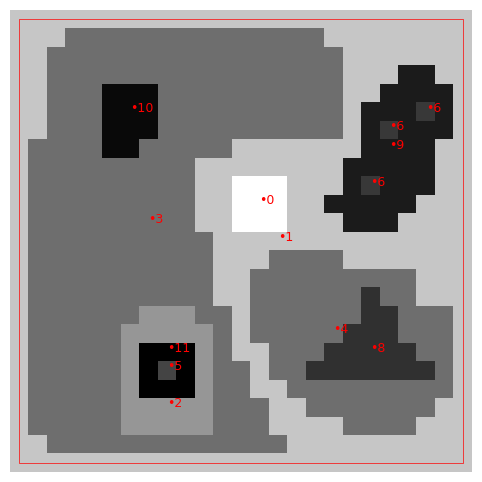

                       0: 253: 625 
                            |
                       1: 203: 616 
            ┌───────────────┴──┬────────────┐
       2: 161: 277         4: 126: 84   6: 80: 38 
      ┌─────┴──────┐           |            |     
 3: 126: 244    5: 90: 9   8: 72: 18    9: 54: 35 
      |            |                              
  10: 38: 11   11: 30: 8 



Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


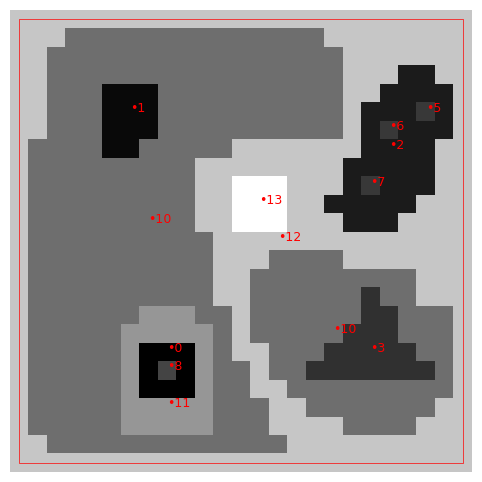

                                              0: 30: 625 
                                  ┌───────────────┴───────────────┐
                              1: 38: 616                       8: 90: 1 
                                  |                                     
                              2: 54: 605                                
             ┌───────────────────┬┴─────────┬──────────┐                
         3: 72: 567           5: 80: 1   6: 80: 1   7: 80: 1            
             |                                                          
        10: 126: 549                                                    
      ┌──────┴───────┐                                                  
 12: 203: 226   11: 161: 24                                             
      |                                                                 
  13: 253: 9 


In [14]:
#adjust = mta.ComponentTreeAdjustmentByLeaf(mintree, maxtree)

adjust.updateTree(maxtree, L)

#after, pruning the maxtree
adjust.prunning(mintree, L)
del L

#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )
mta_utils.showTree(mintree)
print("\n\n")
mta_utils.showTree(maxtree)